In [1]:
import numpy as np
import pandas as pd
from pathlib import Path

# visualization
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

## Read files from OSF

In [2]:
url_all = "https://osf.io/3grcz/download"
url_abstract_screening = "https://osf.io/puwrd/download"
url_included = "https://osf.io/vuyhq/download"

In [3]:
df_excluded = pd.read_csv(url_all, usecols=lambda column: column not in ["Unnamed: 14"])
df_abstract_screening = pd.read_csv(url_abstract_screening, usecols=lambda column: column not in ["Unnamed: 14"])
df_included = pd.read_csv(url_included)

## Clean datasets

### Step 1: Add `record_id`, `label_included` & `label_abstract_screening`

In [4]:
# lowercase column names
df_excluded.columns = map(str.lower, df_excluded.columns)
df_abstract_screening.columns = map(str.lower, df_abstract_screening.columns)
df_included.columns = map(str.lower, df_included.columns)

In [5]:
# add labels
df_included["label_included"] = 1
df_included["label_abstract_screening"] = 1
df_abstract_screening["label_abstract_screening"] = 1

In [6]:
# merge datasets
df_all = df_included.append(df_abstract_screening, sort=False).append(df_excluded, sort=False).reset_index(drop=True)
df_all.rename(columns={"published year": "year"}, inplace=True)

In [7]:
# add record_id
df_all.insert(0, "record_id", df_all.index + 1)

In [8]:
# add labels
df_all.loc[df_all.label_included.isna(), "label_included"] = 0
df_all.loc[df_all.label_abstract_screening.isna(), "label_abstract_screening"] = 0
df_all.label_included = df_all.label_included.astype(int)
df_all.label_abstract_screening = df_all.label_abstract_screening.astype(int)

### Step 2: Find duplicate records and add `duplicate_record_id`

In [9]:
# find duplicates based on title and authors
df_all = df_all.assign(title_clean=df_all["title"].str.replace("[^A-Za-z0-9]", "", regex=True).str.lower())
df_all = df_all.assign(authors_clean=df_all["authors"].str.replace("[^A-Za-z0-9]", "", regex=True).str.lower())
df_all.sort_values(["label_included", "label_abstract_screening"], ascending=False, inplace=True)
duplicate = df_all.duplicated(subset=["title_clean", "authors_clean"])
df_all["duplicate_record_id"] = np.where(duplicate, 1, np.nan)

In [10]:
# if duplicate, duplicate_id indicates the corresponding record_id, otherwise NA
for i in range(len(df_all)):
    if df_all.loc[i, "duplicate_record_id"] == 1:
        df_all.loc[i, "duplicate_record_id"] = df_all.loc[~duplicate & df_all.loc[~duplicate, "title_clean"].isin([df_all.loc[i, "title_clean"]]) & df_all.loc[~duplicate, "authors_clean"].isin([df_all.loc[i, "authors_clean"]]), "record_id"].tolist()
df_all.duplicate_record_id = df_all.duplicate_record_id.astype("Int64")

### Step 3: Sort by orginal order and retain useful columns

In [11]:
df_all.sort_values("record_id", inplace=True)
df_all = df_all[["record_id", "title", "abstract", "authors", "year", "doi", "label_included", "label_abstract_screening", "duplicate_record_id"]]

## Export datasets

In [12]:
Path("output").mkdir(parents=True, exist_ok=True)
df_all.to_csv("output/van_Dis_2020.csv", index=False)

## Datasets statistics

### Summary of inclusions and exclusions

In [13]:
n = len(df_all)
n_dup = (~df_all["duplicate_record_id"].isna()).sum()
n_wo_dup = n - n_dup
n_inc = df_all.loc[df_all.duplicate_record_id.isna(), "label_included"].sum()
n_inc_abs = df_all.loc[df_all.duplicate_record_id.isna(), "label_abstract_screening"].sum()
n_exc = n_wo_dup - n_inc
n_exc_abs = n_wo_dup - n_inc_abs
n_exc_full = n_inc_abs - n_inc

print("Total number of papers:                     ", n, "(includes", n_dup, "duplicates) \n")
print("Total number of papers without duplicates:  ", n_wo_dup, "\n\n")
print("Following statistics calculated without duplicates: \n")
print("Total number of EXCLUSIONS:                 ", n_exc, "\n")
print("Total EXCLUSIONS after abstract screening:  ", n_exc_abs, "\n")
print("Total INCLUSIONS after abstract screening:  ", n_inc_abs, "\n")
print("Total EXCLUSIONS after full text screening: ", n_exc_full, "\n")
print("Total INCLUSIONS after full text screening: ", n_inc, " (", round(100*n_inc/n, 2), "% )\n")

Total number of papers:                      10953 (includes 163 duplicates) 

Total number of papers without duplicates:   10790 


Following statistics calculated without duplicates: 

Total number of EXCLUSIONS:                  10717 

Total EXCLUSIONS after abstract screening:   9995 

Total INCLUSIONS after abstract screening:   795 

Total EXCLUSIONS after full text screening:  722 

Total INCLUSIONS after full text screening:  73  ( 0.67 % )



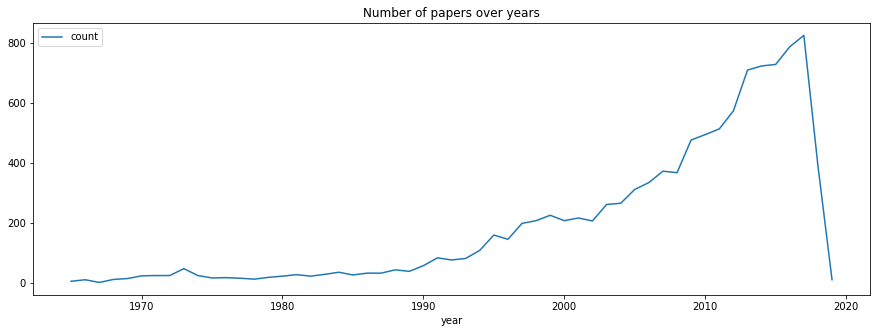

In [14]:
# number of papers over years
df_all.groupby("year").size().reset_index(name="count").set_index("year").plot(figsize=(15,5))
plt.title("Number of papers over years")
plt.show()

### Missingness of title and abstract

In [15]:
print("Number of papers with missing title:              ", df_all["title"].isna().sum(), "\n")
print("Number of papers with missing abstract:           ", df_all["abstract"].isna().sum(), "\n")

Number of papers with missing title:               0 

Number of papers with missing abstract:            438 



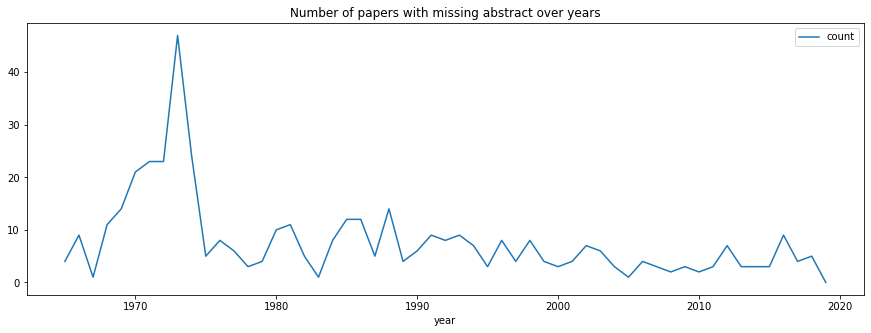

In [16]:
# missing abstract over years
df_all["abstract"].isna().groupby(df_all["year"]).sum().astype(int).\
reset_index(name="count").set_index("year").\
plot(figsize=(15,5))
plt.title("Number of papers with missing abstract over years")
plt.show()

### Word cloud for titles and abstracts

There are 1232890 words in the combination of all titles. 

There are 15947731 words in the combination of all abstracts. 



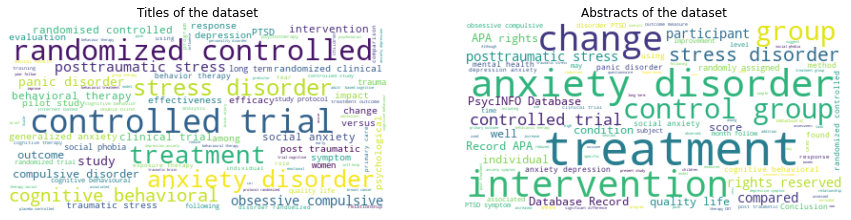

In [17]:
# create stopword list
stopwords = set(STOPWORDS)
stopwords.update(["patient", "patients", "effect", "effects", "result", "results"])

# create word cloud text
title_text = " ".join(word for word in df_all.title.dropna())
abstract_text = " ".join(word for word in df_all.abstract.dropna())
print("There are {} words in the combination of all titles.".format(len(title_text)), "\n")
print("There are {} words in the combination of all abstracts.".format(len(abstract_text)), "\n")

# generate word cloud images
title_wordcloud = WordCloud(stopwords=stopwords, max_words=100, background_color="white").generate(title_text)
abstract_wordcloud = WordCloud(stopwords=stopwords, max_words=100, background_color="white").generate(abstract_text)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=[15, 15])
ax1.imshow(title_wordcloud, interpolation="bilinear")
ax1.set_title("Titles of the dataset")
ax1.axis("off")
ax2.imshow(abstract_wordcloud, interpolation="bilinear")
ax2.set_title("Abstracts of the dataset")
ax2.axis("off")
plt.show()